In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import tensorflow as tf

## Data preprocessing

### Data download

In [6]:
# loading and unzipping the zipped data

# data
with zipfile.ZipFile('/content/drive/MyDrive/leafDataset/data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')



# directories
train_dir = '/content/data/data/train'
validation_dir = '/content/data/data/test'

BATCH_SIZE = 100
IMG_SIZE = (224, 224)

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 9169 files belonging to 2 classes.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1206 files belonging to 2 classes.


Show the first nine images and labels from the training set:

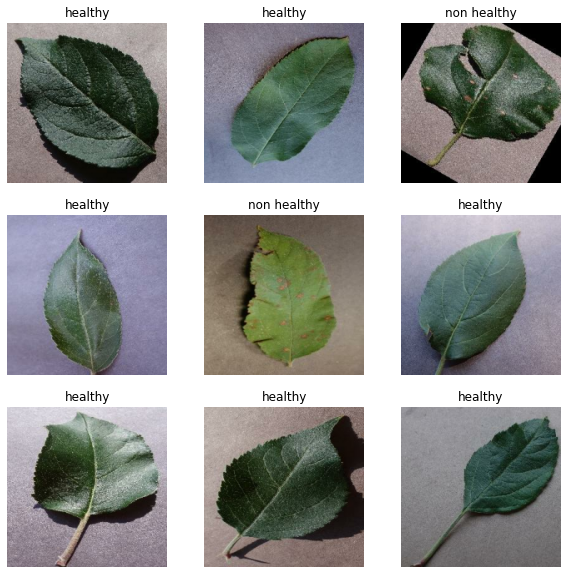

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. 

Let's repeatedly apply these layers to the same image and see the result.

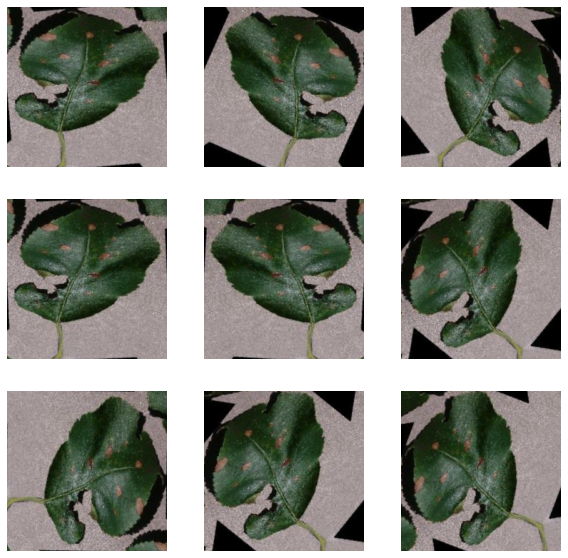

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

Rescale images to`[-1, 1]`from`[0, 255]`. To rescale them, we use mobilenet_v2.

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [14]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Create the base model from the pre-trained convnets
argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [15]:
# Create the base model from the pre-trained model ResNet152
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet.ResNet152(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

234698864/234698864 [==============================] - 7s 0us/step


This feature extractor converts each `224x224x3` image into a `5x5x512` block of features. Let's see what it does to an example batch of images:

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(100, 7, 7, 2048)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### ing lFreeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by settayer.trainable = False) prevents the weights in a given layer from being updated during training. 

In [17]:
base_model.trainable = False

In [18]:
# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single element vector per image.

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(100, 2048)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(100, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers.

In [22]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [25]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 15s 650ms/step - loss: 0.7068 - accuracy: 0.5008


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.50


In [27]:
# Callback

In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5


92/92 [==============================] - 138s 1s/step - loss: 0.7098 - accuracy: 0.5032 - val_loss: 0.7143 - val_accuracy: 0.4809
Epoch 2/5
92/92 [==============================] - 126s 1s/step - loss: 0.6831 - accuracy: 0.5384 - val_loss: 0.7220 - val_accuracy: 0.4627
Epoch 3/5
92/92 [==============================] - 126s 1s/step - loss: 0.6646 - accuracy: 0.5660 - val_loss: 0.7261 - val_accuracy: 0.4685
Epoch 4/5
92/92 [==============================] - 123s 1s/step - loss: 0.6494 - accuracy: 0.5851 - val_loss: 0.7274 - val_accuracy: 0.4809
Epoch 5/5
92/92 [==============================] - 125s 1s/step - loss: 0.6413 - accuracy: 0.6001 - val_loss: 0.7262 - val_accuracy: 0.5000


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss.

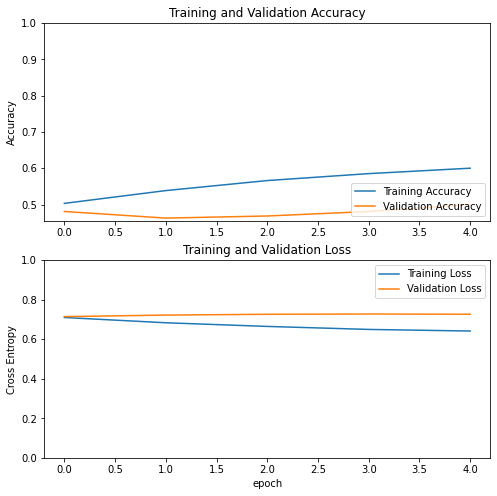

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an ResNet152 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole ResNet152 model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [30]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 121

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  515


In [32]:
# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

### Continue training the model

In [35]:
# callback function to save best weights only
callback_bs = tf.keras.callbacks.ModelCheckpoint(
    filepath= 'model',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [36]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks = callback_bs)

Epoch 5/25


92/92 [==============================] - 295s 2s/step - loss: 0.4984 - accuracy: 0.7275 - val_loss: 0.5311 - val_accuracy: 0.6136
Epoch 6/25
92/92 [==============================] - 227s 2s/step - loss: 0.3365 - accuracy: 0.8315 - val_loss: 0.4091 - val_accuracy: 0.7413
Epoch 7/25
92/92 [==============================] - 223s 2s/step - loss: 0.2940 - accuracy: 0.8721 - val_loss: 0.4321 - val_accuracy: 0.7595
Epoch 8/25
92/92 [==============================] - 227s 2s/step - loss: 0.2540 - accuracy: 0.8890 - val_loss: 0.2682 - val_accuracy: 0.8831
Epoch 9/25
92/92 [==============================] - 226s 2s/step - loss: 0.2296 - accuracy: 0.9014 - val_loss: 0.2334 - val_accuracy: 0.9030
Epoch 10/25
92/92 [==============================] - 223s 2s/step - loss: 0.2020 - accuracy: 0.9126 - val_loss: 0.2330 - val_accuracy: 0.8831
Epoch 11/25
92/92 [==============================] - 225s 2s/step - loss: 0.1780 - accuracy: 0.9266 - val_loss: 0.2232 - val_accuracy: 0.8964
Epoch 12/25
92/92 [===

In [37]:
#loading the best weights
model.load_weights('model')

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last block of ResNet152 base model and training the classifier on top of it. 

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

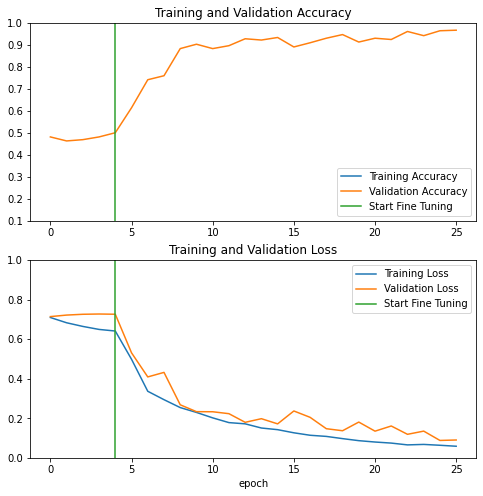

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [40]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   pred = tf.nn.sigmoid(preds)
   pred = tf.where(pred < 0.5, 0, 1)
   y_pred.append(pred)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 49ms/step


In [41]:
y_pred = [item for sublist in y_pred for item in sublist]

label  = []
for i in range(len(y_true)):
  label.append(y_true[i].numpy())

label = [item for sublist in label for item in sublist]

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
acc = accuracy_score(label,y_pred)*100
print(f'Test Accuracy = {acc} %')

Test Accuracy = 97.34660033167496 %


<AxesSubplot:>

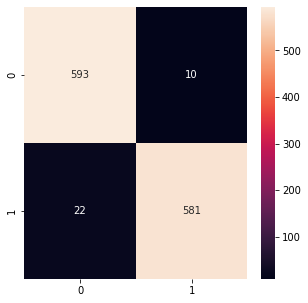

In [43]:
#finding confusion matrix for test data
import seaborn as sns
cnf_matrix= confusion_matrix(label,y_pred)
plt.figure(figsize = (5,5))
sns.heatmap(cnf_matrix, annot=True, fmt='.0f')

In [44]:
print(classification_report(label,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       603
           1       0.98      0.96      0.97       603

    accuracy                           0.97      1206
   macro avg       0.97      0.97      0.97      1206
weighted avg       0.97      0.97      0.97      1206



In [45]:
model.save("ResNet152_unfreeze.h5")